In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = '/content/fake'

In [0]:
#gradient penalty
lambda_gp = 10

In [0]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
   os.makedirs(sample_dir)

In [0]:
# Image processing
transform = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.5,), (0.5,))])
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                  train=True,
                                  transform=transform,
                                  download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=batch_size,
                                         shuffle=True)
# Discriminator
D = nn.Sequential(
   nn.Linear(image_size, hidden_size),
   nn.LeakyReLU(0.2),
   nn.Linear(hidden_size, hidden_size),
   nn.LeakyReLU(0.2),
   nn.Linear(hidden_size, 1))
   
# Generator
G = nn.Sequential(
   nn.Linear(latent_size, hidden_size),
   nn.ReLU(),
   nn.Linear(hidden_size, hidden_size),
   nn.ReLU(),
   nn.Linear(hidden_size, image_size),
   nn.Tanh())


0it [00:00, ?it/s]

9920512it [00:02, 3687509.81it/s]                             


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57328.00it/s]                           
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


1654784it [00:01, 945651.02it/s]                             
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


8192it [00:00, 21260.69it/s]            

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


In [0]:
# Device setting
D = D.to(device)
G = G.to(device)
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=5e-5)
d_optimizer = torch.optim.RMSprop(D.parameters(), lr=5e-5)

def denorm(x):
   out = (x + 1) / 2
   return out.clamp(0, 1)
def reset_grad():
   d_optimizer.zero_grad()
   g_optimizer.zero_grad()

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
   """Calculates the gradient penalty loss for WGAN GP"""
   # Random weight term for interpolation between real and fake samples
   alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
   # Get random interpolation between real and fake samples
   interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
   d_interpolates = D(interpolates)
   fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
   # Get gradient w.r.t. interpolates
   gradients = autograd.grad(
       outputs=d_interpolates,
       inputs=interpolates,
       grad_outputs=fake,
       create_graph=True,
       retain_graph=True,
       only_inputs=True,
   )[0]
   gradients = gradients.view(gradients.size(0), -1)
   gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
   return gradient_penalty

In [0]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
      images = images.reshape(batch_size, -1).to(device)
      # Create the labels which are later used as input for the BCE loss
      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)
      # ================================================================== #
      #                      Train the discriminator                       #
      # ================================================================== #
      # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
      # Second term of the loss is always zero since real_labels == 1
      for w in range(5):
       # outputs = D(images)
       # d_loss_real = criterion(outputs, real_labels)
       # real_score = outputs
       # Compute BCELoss using fake images
       # First term of the loss is always zero since fake_labels == 0
       z = torch.randn(batch_size, latent_size).to(device)
       # fake_images = G(z)
       # outputs = D(fake_images)
       # d_loss_fake = criterion(outputs, fake_labels)
       # fake_score = outputs
       # Dicriminator forward-loss-backward-update
       G_sample = G(z)
       D_real = D(images)
       D_fake = D(G_sample)
       d_loss = -(torch.mean(D_real) - torch.mean(D_fake))
       # Backprop and optimize
       # d_loss = d_loss_real + d_loss_fake
       reset_grad()
       d_loss.backward()
       d_optimizer.step()
       # Weight clipping
       for p in D.parameters():
         p.data.clamp_(-0.01, 0.01)
      # ================================================================== #
      #                        Train the generator                         #
      # ================================================================== #
      # Compute loss with fake images
      z = torch.randn(batch_size, latent_size).to(device)
      #Generator loss:
      G_sample = G(z)
      D_fake = D(G_sample)
      g_loss = -torch.mean(D_fake)
     #  fake_images = G(z)
     #  outputs = D(fake_images)
      # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
      # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
     #  g_loss = criterion(outputs, real_labels)
      # Backprop and optimize
      reset_grad()
      g_loss.backward()
      g_optimizer.step()
      if (i+1) % 200 == 0:
          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                        D_real.mean().item(), D_fake.mean().item()))
  # Save real images
  if (epoch+1) == 1:
      images = images.reshape(images.size(0), 1, 28, 28)
      save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
  # Save sampled images
  fake_images = G_sample.reshape(G_sample.size(0), 1, 28, 28)
  save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

Epoch [0/200], Step [200/600], d_loss: -0.1192, g_loss: -6.4936, D(x): 6.61, D(G(z)): 6.49
Epoch [0/200], Step [400/600], d_loss: -0.0281, g_loss: -4.6065, D(x): 4.64, D(G(z)): 4.61
Epoch [0/200], Step [600/600], d_loss: -0.1813, g_loss: -0.3409, D(x): 0.50, D(G(z)): 0.34
Epoch [1/200], Step [200/600], d_loss: -0.2350, g_loss: -0.6418, D(x): 0.90, D(G(z)): 0.64
Epoch [1/200], Step [400/600], d_loss: -0.1744, g_loss: -0.8368, D(x): 0.98, D(G(z)): 0.84
Epoch [1/200], Step [600/600], d_loss: -0.2001, g_loss: -0.6187, D(x): 0.83, D(G(z)): 0.62
Epoch [2/200], Step [200/600], d_loss: -0.1982, g_loss: -0.5361, D(x): 0.75, D(G(z)): 0.54
Epoch [2/200], Step [400/600], d_loss: -0.2133, g_loss: -0.4884, D(x): 0.69, D(G(z)): 0.49
Epoch [2/200], Step [600/600], d_loss: -0.1749, g_loss: -0.6552, D(x): 0.78, D(G(z)): 0.66
Epoch [3/200], Step [200/600], d_loss: -0.2151, g_loss: -0.7355, D(x): 0.98, D(G(z)): 0.74
Epoch [3/200], Step [400/600], d_loss: -0.3517, g_loss: 0.5829, D(x): -0.27, D(G(z)): -0.5

In [0]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

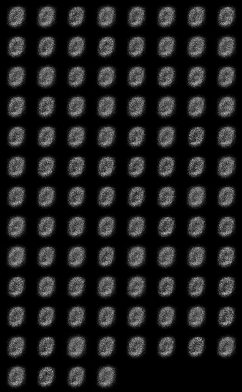

In [3]:
from PIL import Image
i = Image.open(path+'/fake_images-1.png')
i

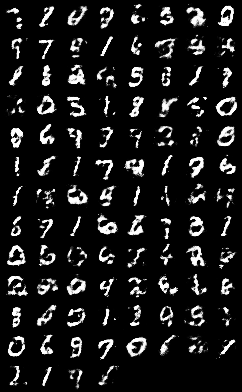

In [4]:
from PIL import Image
i = Image.open(path+'/fake_images-199.png')
i

In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
cntr = 1
for blk in range(20):
img_arr = [cv2.imread('/content/fake/fake_images-'+str(cntr)+'.png')]
cntr += 1
for i in range(1,10):
  img_arr.append(cv2.imread('/content/fake/fake_images-'+str(cntr)+'.png'))
  cntr += 1
pctrs = np.hstack(img_arr)
print("<<<<<<<<<>>>>>>>>>>")
print("Batch :",blk)
print("<<<<<<<<<>>>>>>>>>>")
cv2_imshow(pctrs)